In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import decimal
from multiprocessing import Pool
from functools import partial
from matplotlib.ticker import AutoMinorLocator
import random
import pickle

In [2]:
def tRSSA_target_left(tmax, n0, Ag, nrep):
    np.random.seed() 
    r = 0.065+0.081 *math.exp(-0.3*Ag)    #birth rate of AgNP from chatterjee2015antibacterial
    d = 0.0037*Ag                         #death rate of AgNP from chatterjee2015antibacterial
    dt = 0.1                              #time interval 
    t = 0
    n = n0                               # n0 is the initial number of bacteria 
    nl = n0-0.1*n0                        
    nu = n0+0.1*n0
    nlist = [n0]
    tlist = np.arange(t,tmax+dt,dt)    

    i = 1
    hl = nl
    hu = nu
    c1l = d                   # stochastic rate constant for bacteria to undergo death in time  interval dt in presence of AgNP
    c1u = d
    #effective birth rate r*math.exp(-r*t)
    # l = lower bound , u = upper bound
    c2l = r*math.exp(-r*t)      # stochastic rate constant for bacteria to undergo birth in time  interval dt in presence of AgNP
    c2u = r*math.exp(-r*(t+dt))
    # propensity = no of posible collision*stochastic rate constant = h*c 
    a1l = c1l*hl                # a1l = lower bound propensity for death rxn
    a1u = c1u*hu                # a1u = propensity upper bound for death rxn 
    a2l = c2l*hl                # a2l = propensity lower bound for birth rxn
    a2u = c2u*hu                # a2u = propnsity upper bound for birth rxn
    a0u = a1u + a2u             # a = total propensity 
    update = [-1, 1]            # update = stoichiometry for reaction , so for birth rate no of bacteria increases by 1 and for death it decreases by 1

    tTotlist = [t]              #time list

    while n>0:                  

        greater = True
        j = 0
        while greater == True:
            r1 = np.random.uniform(0,1)  
            tau = -math.log(r1)/a0u 
            t = t+tau

            if t>tlist[i] and i<tmax/dt:            #random time generated should be less than the time bound
                j = j+1 
                t = tlist[i]                      #if time not less then update to this time
                i = i+1
  
                c1l = d
                c1u = d
                c2l = r*math.exp(-r*tlist[i-1])
                c2u = r*math.exp(-r*tlist[i])
                a1l = c1l*hl
                a1u = c1u*hu
                a2l = c2l*hl
                a2u = c2u*hu
                a0u = a1u+a2u  
                
            else: 
                greater = False

        rb = np.random.uniform(0,1,2)              # generating two random numbers to predict which rxn will occur and at what time
        allist = [a1l, a2l]
        aulist = [a1u, a2u]
        ausum = np.cumsum(aulist)                  
        idxlist = np.where(ausum > rb[0]*(a1u+a2u)) 
        idx = idxlist[0][0]                         # finding minimum index which satisfies ausum >rb[0]*(a0u)
   

        accepted = False
        if rb[1] <= allist[idx]/aulist[idx]:      # condition for rxn to be fired
            accepted = True

        else:
            alist = [d*nlist[-1],(r*math.exp(-r*t))*nlist[-1]]
            if rb[1] <= alist[idx]/aulist[idx]:           # success probability
                accepted = True

        if accepted:
            n = nlist[-1] + update[idx]                # updating the state 
 

            if n > hu or n < hl:
                hl = n - 0.1*n
                hu = n + 0.1*n
                c1l = d
                c1u = d
                c2l = r*math.exp(-r*tlist[i-1])
                c2u = r*math.exp(-r*tlist[i])
                a1l = c1l*hl
                a1u = c1u*hu
                a2l = c2l*hl
                a2u = c2u*hu
                a0u = a1u+a2u 


        tTotlist.append(t)
        nlist.append(n)
    return (tTotlist, nlist)

In [3]:
n0s  = [10,100,1000]        # initial bacterial population 
tmax = 30000 
Ags  = [4,9,49,99]          # AgNP concentration in micromolar
for Ag in Ags:
    print('Ag = {}'.format(Ag))
    r = 0.065+0.081 *math.exp(-0.3*Ag)   
    d = 0.0037*Ag                        
    for n0 in n0s:
        nreps = list(range(0,1000))
        pool = Pool(processes=3)
        func = partial(tRSSA_target_left,tmax,n0,Ag)
        result = pool.map(func,nreps)
        pool.close()
        pool.join()
        trajectory = result
        fname = "/home/rati/Downloads/nafisa/ag/traj_dt_0.1_a0u2_added_fraction_target_left_over_d_{0}_n0_{1}_Ag_{2}.p".format(d,n0,Ag)
        pickle_out = open(fname,"wb")
        pickle.dump(trajectory, pickle_out)
        pickle_out.close()

Ag = 4.0
0.08939673116488837
0.0148
Ag = 9
0.07044364653191973
0.0333
Ag = 49
0.06500003344692028
0.18130000000000002
Ag = 99
0.06500000000001023
0.3663


[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
[8, 7, 6, 6, 5, 4, 3, 2, 1, 0]
[7, 6, 6, 5, 4, 3, 3, 2, 1, 0]
[7, 6, 5, 4, 3, 3, 2, 1, 1, 0]
[7, 6, 5, 5, 5, 4, 3, 2, 1, 0]
[8, 7, 6, 5, 4, 3, 3, 2, 1, 0]
[7, 6, 5, 4, 3, 2, 1, 1, 1, 0]
[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


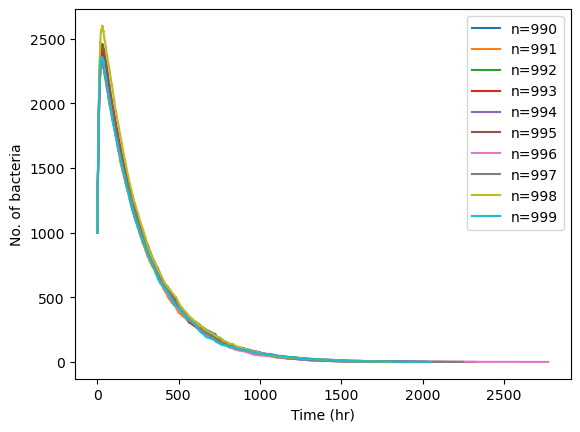

In [15]:
Ags = [1]              
n0  = 1000
for i in range(len(Ags)):
    Ag = Ags[i]
    r  = 0.065+0.081 *math.exp(-0.3*Ag)
    d  = 0.0037*Ag
    fname =  "/home/rati/Downloads/nafisa/ag/traj_dt_0.1_a0u2_added_fraction_target_left_over_d_{0}_n0_{1}_Ag_{2}.p".format(d,n0,Ag)
    with open(fname, 'rb') as fr:
        try:
            while True:
                data = pickle.load(fr)
                for j in range(990,1000):
                    tTotlist = data[j][0]
                    nlist = data[j][1]
                    print(nlist[-10:])
                    plt.plot(tTotlist,nlist,label='n={}'.format(j))
                    plt.legend()
                    plt.xlabel('Time (hr)')
                    plt.ylabel('No. of bacteria')

        except EOFError:
            pass
    fr.close()

1000
[7, 6, 5, 4, 5, 4, 3, 2, 1, 0]
[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
[7, 6, 5, 4, 4, 4, 3, 2, 1, 0]
[8, 7, 6, 5, 4, 3, 3, 2, 1, 0]
[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
[7, 7, 6, 5, 4, 3, 2, 1, 1, 0]
[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
[7, 6, 6, 5, 4, 4, 3, 2, 1, 0]
[8, 7, 7, 6, 5, 4, 3, 2, 1, 0]


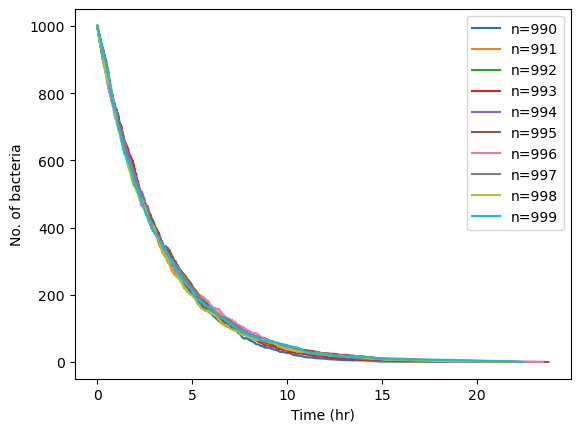

In [16]:
Ags =[100]
n0= 1000
for i in range(len(Ags)):
    Ag = Ags[i]
    r = 0.065+0.081 *math.exp(-0.3*Ag)
    d = 0.0037*Ag
    fname =  "/home/rati/Downloads/nafisa/ag/traj_dt_0.1_a0u2_added_fraction_target_left_over_d_{0}_n0_{1}_Ag_{2}.p".format(d,n0,Ag)
    with open(fname, 'rb') as fr:
        try:
            while True:
                data = pickle.load(fr)
                print(len(data))
                for j in range(990,1000):
                    tTotlist = data[j][0]
                    nlist = data[j][1]
                    print(nlist[-10:])
                    plt.plot(tTotlist,nlist,label='n={}'.format(j))
                    plt.legend()
                    plt.xlabel('Time (hr)')
                    plt.ylabel('No. of bacteria')
        except EOFError:
            pass
    fr.close()

[261.9804971875774]
[261.9804971875774, 424.4397207478979]
[261.9804971875774, 424.4397207478979, 572.5321993411249]
[116.04515229692373]
[116.04515229692373, 186.09037527805216]
[116.04515229692373, 186.09037527805216, 253.70992539218452]
[18.88200640894698]
[18.88200640894698, 33.14836529142849]
[18.88200640894698, 33.14836529142849, 46.35683259743471]
[8.816482534288454]
[8.816482534288454, 15.918945068118616]
[8.816482534288454, 15.918945068118616, 22.456539620790622]


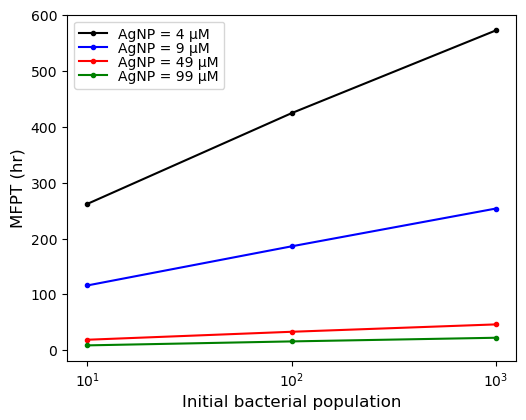

In [4]:
xpos = -0.1
ypos = 1.10
markers_sim = ['ko','bo','ro','go','yo']
markers_calc = ['k.-','b.-','r.-','g.-','y.-']
n0s = [10,100,1000]
Ags = [4,9,49,99]
nreps=1000                   # no of replicates = 1000
j = 0
for Ag in Ags:
    r = 0.065+0.081 *math.exp(-0.3*Ag)
    d = 0.0037*Ag
    Tmeans = []
    Tvars = []
    Tstds = []
    Fano = []
    CV = []
    R = []

    for i in range(len(n0s)):
        n0 = n0s[i]
        fname =  "/home/rati/Downloads/nafisa/ag/traj_dt_0.1_a0u2_added_fraction_target_left_over_d_{0}_n0_{1}_Ag_{2}.p".format(d,n0,Ag)
        with open(fname, 'rb') as fr:
            try:
                while True:
                    data = pickle.load(fr)
                    fptList = []
                    for ni in range(nreps):
                        fpt = data[ni][0][-1]
                        fptList.append(fpt)
                    Tmean = np.mean(fptList)
                    Tvar = np.var(fptList)
                    Tstd = np.std(fptList)
                    Tmeans.append(Tmean)
                    Tvars.append(Tvar)
                    Tstds.append(Tstd)
                    Fano.append(Tvar/Tmean)
                    R.append(Tvar/(Tmean**2))
                    CV.append(Tstd/Tmean)
            except EOFError:
                pass
        fr.close()
        print(Tmeans)
    plt.plot(n0s, Tmeans, markers_calc[j], label='AgNP = {} \u03bcM'.format(Ags[j]))
    plt.ylabel('MFPT (hr)',fontsize = 12)

    j = j +1

plt.xlabel('Initial bacterial population',fontsize = 12)
plt.tick_params(which='minor',color='w')
fig = plt.gcf()
fig.set_size_inches(5.8,4.5)
plt.legend( loc="best",bbox_transform=fig.transFigure, ncol=1,labelspacing=0)
plt.xscale('log')
fig.savefig('ag MFPT wrtN Kconst Avar', dpi=1200)
plt.show()

(array([ 79., 289., 293., 191.,  82.,  32.,  19.,  10.,   3.,   2.]),
 array([ 7.23245022,  8.53957333,  9.84669645, 11.15381957, 12.46094269,
        13.76806581, 15.07518893, 16.38231205, 17.68943516, 18.99655828,
        20.3036814 ]),
 <BarContainer object of 10 artists>)

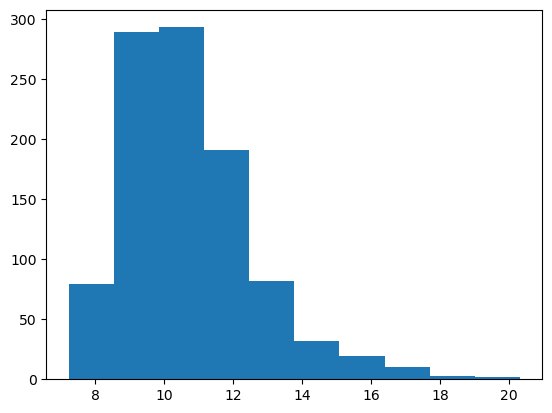

In [18]:
plt.hist(fptList)